In [1]:
import datetime
import gc
import joblib
import json
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import optuna
import os
import scipy.stats
import seaborn as sns
import sys
sys.path.append("../")
sys.path.append("../../")
import time
import warnings
warnings.simplefilter("ignore")
from imblearn.over_sampling import SMOTE
from itertools import repeat
from lightgbm import LGBMClassifier, log_evaluation
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, fbeta_score, make_scorer
from tqdm import tqdm

In [2]:
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
from cycler import cycler
from IPython.display import display
from colorama import Fore, Back, Style
plt.rcParams['axes.facecolor'] = '#0057b8' # blue
plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])
plt.rcParams['text.color'] = 'w'

In [3]:
from utils.common import (
    sigmoid, pad_column_name
)
from utils.constants import *
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.eda_helpers import (
    plot_missing_proportion_barchart, 
    get_cols
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, NON_FEATURE_COLUMNS,
    MEAN_FEATURES, MIN_FEATURES, MAX_FEATURES, LAST_FEATURES, FIRST_FEATURES,
    RANGE_FEATURES, VELOCITY_FEATURES, SPEED_FEATURES
)

In [4]:
%load_ext autoreload
%autoreload

### Read Data

In [5]:
%%time
train_agg = read_file(f"../{PROCESSED_DATA_PATH}/v2/train_agg.pkl")

Shape of data: (458913, 4083)
CPU times: user 4.08 s, sys: 14.1 s, total: 18.2 s
Wall time: 26.6 s


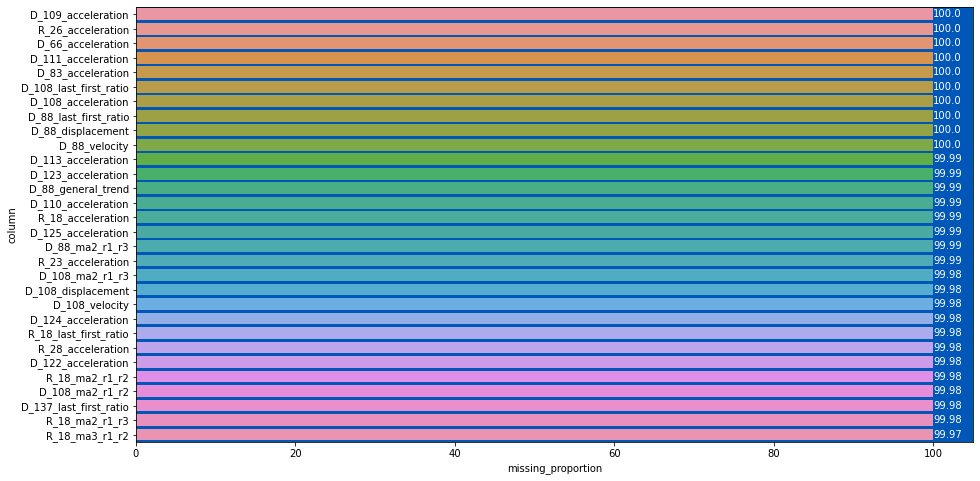

In [6]:
# train_agg = train_agg.loc[:, [c for c in train_agg.columns if c.endswith("_last")]]
# train_agg = train_agg.drop(columns=[c for c in train_agg.columns if c.endswith("_third_last")])
# train_agg = train_agg.drop(columns=[c for c in train_agg.columns if c.endswith("_second_last")])
m = plot_missing_proportion_barchart(train_agg)

In [7]:
labels = read_file(f"../{RAW_DATA_PATH}/train_labels.csv")

Shape of data: (458913, 2)


In [8]:
high_missing_columns = m.loc[m["missing_proportion"] > 99]["column"].tolist()
len(high_missing_columns)

227

In [9]:
%%time
train_agg = train_agg.drop(columns=high_missing_columns, errors="ignore")

CPU times: user 1.27 s, sys: 6.26 s, total: 7.53 s
Wall time: 11.4 s


In [10]:
train_agg.shape

(458913, 3856)

### Pre-train Feature Reduction

In [11]:
def select_noob_features(feature_imp_df, threshold):
    noob_features = []
    for type_ in feature_imp_df.columns[1:]:
        noob_features.extend(
            (
                feature_imp_df.loc[feature_imp_df[type_] < threshold]["base_feature"] + "_" + type_
            ).tolist()
        )
    print(len(noob_features), feature_imp_df.shape[0] * (feature_imp_df.shape[1] - 1))
    return noob_features

In [12]:
def get_feature_imp_percentile(summary_df, p):
    array = pd.Series(np.stack(summary_df.drop(columns="base_feature", errors="ignore").values).ravel()).dropna().values
    return np.percentile(array, p)

In [13]:
# features_to_drop = set()
# for i, threshold_percentile in zip(range(5, 10), repeat(10)):
#     print(f"Read file {i}")
#     summary_feature_imp = read_file(f"../{EXP_PATH}/feature_imp_summary{i}.csv")
#     feature_imp_thr = get_feature_imp_percentile(summary_feature_imp, threshold_percentile)
#     # feature_imp_thr = 2
#     drop_feature_subset = set(select_noob_features(summary_feature_imp, feature_imp_thr))
#     features_to_drop = features_to_drop.union(drop_feature_subset)
#     print(f"Threshold = {feature_imp_thr:.2f}, Dropping # of features {len(drop_feature_subset)}")

In [16]:
# Get previous experiment feature importance
feature_imp_df = read_file(f"../2.lgbm_dart_1020_full_fix/feature_importance.csv")

Shape of data: (184, 24)


In [17]:
good_features = []
for type_ in feature_imp_df.columns[1:]:
    good_features.extend(
        (
            feature_imp_df.loc[feature_imp_df[type_] > 2]["base_feature"] + "_" + type_
        ).tolist()
    )

In [18]:
len(good_features)

3028

In [19]:
# %%time
# train_agg = train_agg.drop(columns=list(features_to_drop), errors="ignore")
# train_agg.shape

In [20]:
%%time
train_agg = train_agg.loc[:, good_features]
train_agg.shape

CPU times: user 379 ms, sys: 2.13 s, total: 2.51 s
Wall time: 3.83 s


(458913, 3028)

In [21]:
target = labels["target"].values

In [22]:
%%time
train_agg = train_agg.drop(columns=NON_FEATURE_COLUMNS + ["target"], errors="ignore")
gc.collect()

CPU times: user 412 ms, sys: 2.18 s, total: 2.59 s
Wall time: 3.87 s


10663

In [23]:
cat_columns = train_agg.select_dtypes("category").columns.to_list()

In [24]:
%%time
train_agg = train_agg.drop(columns=get_cols(train_agg, "a_"), errors="ignore")
gc.collect()

CPU times: user 393 ms, sys: 2.25 s, total: 2.64 s
Wall time: 3.75 s


0

In [25]:
%%time
train_agg = train_agg.drop(columns=get_cols(train_agg, "third_last"), errors="ignore")
gc.collect()

CPU times: user 405 ms, sys: 2.1 s, total: 2.5 s
Wall time: 3.64 s


0

In [26]:
train_agg.shape, target.shape

((458913, 3028), (458913,))

### Train LGBM using pre-set hyperparams

In [27]:
seed = 6666

In [28]:
params = {
    'objective': 'binary',
    'metric': "binary_logloss",
    'boosting': 'dart',
    'seed': seed,
    'num_leaves': 90,
    'learning_rate': 0.01,
    'feature_fraction': 0.2,
    'bagging_freq': 10,
    'bagging_fraction': 0.55,
    'n_jobs': -1,
    'lambda_l2': 20,
    'min_data_in_leaf': 120,
    'scale_pos_weight': 1.35
}

In [29]:
# # Create a numpy array to store test predictions
# test_predictions = np.zeros(len(test_agg))
# Create a numpy array to store out of folds predictions
oof_predictions = np.zeros(len(train_agg))

In [35]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [34]:
target = labels["target"].values

In [32]:
cat_features = train_agg.select_dtypes("category").columns

In [33]:
for fold, (trn_ind, val_ind) in enumerate(kfold.split(train_agg, target)):
    print(' ')
    print('-'*50)
    print(f'Training fold {fold} with {train_agg.shape[1]} features...')
    print('-'*50)
    x_train, x_val = train_agg.iloc[trn_ind], train_agg.iloc[val_ind]
    y_train, y_val = target[trn_ind], target[val_ind]
    lgb_train = lgb.Dataset(x_train, y_train, categorical_feature=cat_features.tolist())
    lgb_valid = lgb.Dataset(x_val, y_val, categorical_feature=cat_features.tolist())
    model = lgb.train(
        params = params,
        train_set = lgb_train,
        num_boost_round = 12500,
        valid_sets = [lgb_train, lgb_valid],
        early_stopping_rounds = 300,
        verbose_eval = 1000,
        feval = lgb_amex_metric
    )
    # Save best model
    joblib.dump(model, f'./models/model_fold{fold}_seed{seed}.pkl')
    # Predict validation
    y_val_pred = model.predict(x_val, raw_score=True)
    # # Add to out of folds array
    # oof_predictions[val_ind] = val_pred
    # Predict the test set
    # test_pred = model.predict(test[features])
    # test_predictions += test_pred / CFG.n_folds
    # Compute fold metric
    val_score, val_g, val_t4 = amex_metric(y_val, y_val_pred)                                      
    print(f'Our fold {fold} CV score is {val_score}')
    del x_train, x_val, y_train, y_val, lgb_train, lgb_valid
    gc.collect()

 
--------------------------------------------------
Training fold 0 with 3028 features...
--------------------------------------------------
[LightGBM] [Info] Number of positive: 95062, number of negative: 272068
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.869707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 485676
[LightGBM] [Info] Number of data points in the train set: 367130, number of used features: 3028
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258933 -> initscore=-1.051523
[LightGBM] [Info] Start training from score -1.051523
[1000]	training's binary_logloss: 0.259518	training's amex: 0.786689	valid_1's binary_logloss: 0.265656	valid_1's amex: 0.7701
[2000]	training's binary_logloss: 0.215648	training's amex: 0.811208	valid_1's binary_logloss: 0.229154	valid_1's amex: 0.783525
[3000]	training's binary_logloss: 0

### Previous Experiment

In [40]:
for fold, (trn_ind, val_ind) in enumerate(kfold.split(train_agg, target)):
    print(' ')
    print('-'*50)
    print(f'Training fold {fold} with {train_agg.shape[1]} features...')
    print('-'*50)
    x_train, x_val = train_agg.iloc[trn_ind], train_agg.iloc[val_ind]
    y_train, y_val = target[trn_ind], target[val_ind]
    lgb_train = lgb.Dataset(x_train, y_train, categorical_feature=cat_features.tolist())
    lgb_valid = lgb.Dataset(x_val, y_val, categorical_feature=cat_features.tolist())
    model = lgb.train(
        params = params,
        train_set = lgb_train,
        num_boost_round = 10000,
        valid_sets = [lgb_train, lgb_valid],
        early_stopping_rounds = 300,
        verbose_eval = 500,
        feval = lgb_amex_metric
    )
    # Save best model
    joblib.dump(model, f'{EXP_PATH}/lgbm_dart_923_full_fix/models/model_fold{fold}_seed{seed}.pkl')
    # Predict validation
    y_val_pred = model.predict(x_val, raw_score=True)
    # # Add to out of folds array
    # oof_predictions[val_ind] = val_pred
    # Predict the test set
    # test_pred = model.predict(test[features])
    # test_predictions += test_pred / CFG.n_folds
    # Compute fold metric
    val_score, val_g, val_t4 = amex_metric(y_val, y_val_pred)                                      
    print(f'Our fold {fold} CV score is {val_score}')
    del x_train, x_val, y_train, y_val, lgb_train, lgb_valid
    gc.collect()

 
--------------------------------------------------
Training fold 0 with 2526 features...
--------------------------------------------------
[LightGBM] [Info] Number of positive: 95062, number of negative: 272068
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.460335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400600
[LightGBM] [Info] Number of data points in the train set: 367130, number of used features: 2509
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258933 -> initscore=-1.051523
[LightGBM] [Info] Start training from score -1.051523
[500]	training's binary_logloss: 0.293739	training's amex: 0.77623	valid_1's binary_logloss: 0.297458	valid_1's amex: 0.764339
[1000]	training's binary_logloss: 0.241355	training's amex: 0.793123	valid_1's binary_logloss: 0.248443	valid_1's amex: 0.77557
[1500]	training's binary_logloss: 0.

In [ ]:
for fold, (trn_ind, val_ind) in enumerate(kfold.split(train_agg, target)):
    print(' ')
    print('-'*50)
    print(f'Training fold {fold} with {train_agg.shape[1]} features...')
    print('-'*50)
    x_train, x_val = train_agg.iloc[trn_ind], train_agg.iloc[val_ind]
    y_train, y_val = target[trn_ind], target[val_ind]
    lgb_train = lgb.Dataset(x_train, y_train, categorical_feature=cat_features.tolist())
    lgb_valid = lgb.Dataset(x_val, y_val, categorical_feature=cat_features.tolist())
    model = lgb.train(
        params = params,
        train_set = lgb_train,
        num_boost_round = 8000,
        valid_sets = [lgb_train, lgb_valid],
        early_stopping_rounds = 200,
        verbose_eval = 500,
        feval = lgb_amex_metric
    )
    # Save best model
    joblib.dump(model, f'{EXP_PATH}/lgbm_dart_923_half_fix/models/model_fold{fold}_seed{seed}.pkl')
    # Predict validation
    y_val_pred = model.predict(x_val, raw_score=True)
    # # Add to out of folds array
    # oof_predictions[val_ind] = val_pred
    # Predict the test set
    # test_pred = model.predict(test[features])
    # test_predictions += test_pred / CFG.n_folds
    # Compute fold metric
    val_score, val_g, val_t4 = amex_metric(y_val, y_val_pred)                                      
    print(f'Our fold {fold} CV score is {val_score}')
    del x_train, x_val, y_train, y_val, lgb_train, lgb_valid
    gc.collect()

 
--------------------------------------------------
Training fold 0 with 3548 features...
--------------------------------------------------
[LightGBM] [Info] Number of positive: 95062, number of negative: 272068
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.835258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 575879
[LightGBM] [Info] Number of data points in the train set: 367130, number of used features: 3546
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258933 -> initscore=-1.051523
[LightGBM] [Info] Start training from score -1.051523
[500]	training's binary_logloss: 0.313021	training's amex: 0.775501	valid_1's binary_logloss: 0.31639	valid_1's amex: 0.761438
[1000]	training's binary_logloss: 0.251784	training's amex: 0.790594	valid_1's binary_logloss: 0.25824	valid_1's amex: 0.773174
[1500]	training's binary_logloss: 0.

In [77]:
y_val_pred = model.predict(x_val, raw_score=True)
val_score, val_g, val_t4 = amex_metric(y_val, y_val_pred)

NameError: name 'x_val' is not defined

In [78]:
val_score, val_g, val_t4

(0.7993821694220526, 0.9270201772619467, 0.6717441615821587)

In [64]:
del x_train, x_val, y_train, y_val, lgb_train, lgb_valid

In [ ]:
# Compute out of folds metric
score = amex_metric(train[CFG.target], oof_predictions)
print(f'Our out of folds CV score is {score}')
# Create a dataframe to store out of folds predictions
oof_df = pd.DataFrame({'customer_ID': train['customer_ID'], 'target': train[CFG.target], 'prediction': oof_predictions})
oof_df.to_csv(f'oof_lgbm_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)
# Create a dataframe to store test prediction
test_df = pd.DataFrame({'customer_ID': test['customer_ID'], 'prediction': test_predictions})
test_df.to_csv(f'test_lgbm_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)

### Tune LGBM using Optuna (KFold)

In [22]:
CURRENT_EXP_PATH = f"{EXP_PATH}/lgbm_gbdt_clean_agg_exp2"
CURRENT_EXP_PATH

'../experiments/lgbm_gbdt_clean_agg_exp2'

In [125]:
with open(f"{CURRENT_EXP_PATH}/best_scores.json", "r+") as outfile:
    best_scores_json = json.load(outfile)
np.mean(list(best_scores_json["validation"].values()))

0.7958662214261033

In [127]:
def objective(trial):
    kf = StratifiedKFold(n_splits=5) # , shuffle=True, random_state=1020
    params = {
        "objective": "binary",
        "metrics": "custom",
        "first_metric_only": True, 
        "boost_from_average": False,
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 1,
        "learning_rate": 0.025,
        "n_estimators": 1500,
        "max_bins": 127,
        "subsample_freq": 2,
        "min_child_samples": 1500,
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 0.1, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 5, 30, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 0.25),
        "subsample": trial.suggest_float("subsample", 0.65, 0.75),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.3, 2),
        "num_leaves": trial.suggest_int("num_leaves", 75, 120)
    }
    print(
        "alpha", round(params["reg_alpha"], 4), 
        "lambda", round(params["reg_lambda"], 4),
        "colsample_bytree", round(params["colsample_bytree"], 3),
        "subsample", round(params["subsample"], 3), 
        "scale_pos_weight", round(params["scale_pos_weight"], 3), 
        "num_leaves", round(params["num_leaves"], 0)
    )
    train_score_list, val_score_list = [], []
    for fold, (idx_tr, idx_va) in zip(range(1, 5+1), kf.split(train_agg, target)):
        fold = str(fold)
        X_train, y_train = train_agg.iloc[idx_tr], target[idx_tr]
        train_data = lgb.Dataset(
            X_train,
            y_train
        )
        X_val, y_val = train_agg.iloc[idx_va], target[idx_va], 
        valid_data = lgb.Dataset(
            X_val,
            y_val,
            reference=train_data
        )
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=UserWarning)
            model = lgb.train(
                params=params,
                train_set=train_data, 
                valid_sets=[valid_data, train_data], 
                feval=lgb_amex_metric, 
                early_stopping_rounds=200,
                categorical_feature=cat_columns,
                callbacks=[
                    log_evaluation(100),
                ]
            )
        y_train_pred = model.predict(X_train, raw_score=True)
        train_score, train_g, train_t4 = amex_metric(y_train, y_train_pred)
        train_data, X_train, y_train = None, None, None
        y_val_pred = model.predict(X_val, raw_score=True)
        val_score, val_g, val_t4 = amex_metric(y_val, y_val_pred)
        valid_data, X_val, y_val = None, None, None
        train_score_list.append(train_score)
        val_score_list.append(val_score)
        if val_score > best_scores_json["validation"][fold]:
            best_scores_json["train"][fold] = train_score
            best_scores_json["validation"][fold] = val_score
            with open(f'{CURRENT_EXP_PATH}/best_scores.json', "w") as outfile:
                json.dump(best_scores_json, outfile)
            joblib.dump(model, f'{CURRENT_EXP_PATH}/models/model{fold}.pkl')
        elif np.mean(train_score_list) >= np.mean(list(best_scores_json["train"].values())) + 0.02:
            print(f"Train score too high (overfitting), start a new trial")
            return np.mean(val_score_list)
        print(f"{Fore.BLUE}{Style.BRIGHT}Fold {fold} | Train Score = {train_score:.5f} ({train_g:.4f}, {train_t4:.4f})")
        print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | Val Score = {val_score:.5f} ({val_g:.4f}, {val_t4:.4f}){Style.RESET_ALL}")
        print(f"Clear cache {gc.collect()}")
        
    return np.mean(val_score_list)

In [39]:
# study = joblib.load(f"{CURRENT_EXP_PATH}/optuna_study.pkl")

In [129]:
# study = optuna.create_study(direction="maximize")

[I 2022-07-29 03:43:35,484] A new study created in memory with name: no-name-f47c98f4-d772-41dd-9033-0954e5ba2b67


In [32]:
# study.optimize(objective, n_trials=15)

In [ ]:
def train_and_evaluate(train, test):
    # Label encode categorical features
    cat_features = [
        "B_30",
        "B_38",
        "D_114",
        "D_116",
        "D_117",
        "D_120",
        "D_126",
        "D_63",
        "D_64",
        "D_66",
        "D_68"
    ]
    cat_features = [f"{cf}_last" for cf in cat_features]
    for cat_col in cat_features:
        encoder = LabelEncoder()
        train[cat_col] = encoder.fit_transform(train[cat_col])
        test[cat_col] = encoder.transform(test[cat_col])
    # Round last float features to 2 decimal place
    num_cols = list(train.dtypes[(train.dtypes == 'float32') | (train.dtypes == 'float64')].index)
    num_cols = [col for col in num_cols if 'last' in col]
    for col in num_cols:
        train[col + '_round2'] = train[col].round(2)
        test[col + '_round2'] = test[col].round(2)
    # Get the difference between last and mean
    num_cols = [col for col in train.columns if 'last' in col]
    num_cols = [col[:-5] for col in num_cols if 'round' not in col]
    for col in num_cols:
        try:
            train[f'{col}_last_mean_diff'] = train[f'{col}_last'] - train[f'{col}_mean']
            test[f'{col}_last_mean_diff'] = test[f'{col}_last'] - test[f'{col}_mean']
        except:
            pass
    # Transform float64 and float32 to float16
    num_cols = list(train.dtypes[(train.dtypes == 'float32') | (train.dtypes == 'float64')].index)
    for col in tqdm(num_cols):
        train[col] = train[col].astype(np.float16)
        test[col] = test[col].astype(np.float16)
    # Get feature list
    features = [col for col in train.columns if col not in ['customer_ID', CFG.target]]
    params = {
        'objective': 'binary',
        'metric': "binary_logloss",
        'boosting': 'dart',
        'seed': CFG.seed,
        'num_leaves': 100,
        'learning_rate': 0.01,
        'feature_fraction': 0.20,
        'bagging_freq': 10,
        'bagging_fraction': 0.50,
        'n_jobs': -1,
        'lambda_l2': 2,
        'min_data_in_leaf': 40
        }
    # Create a numpy array to store test predictions
    test_predictions = np.zeros(len(test))
    # Create a numpy array to store out of folds predictions
    oof_predictions = np.zeros(len(train))
    kfold = StratifiedKFold(n_splits = CFG.n_folds, shuffle = True, random_state = CFG.seed)
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, train[CFG.target])):
        print(' ')
        print('-'*50)
        print(f'Training fold {fold} with {len(features)} features...')
        x_train, x_val = train[features].iloc[trn_ind], train[features].iloc[val_ind]
        y_train, y_val = train[CFG.target].iloc[trn_ind], train[CFG.target].iloc[val_ind]
        lgb_train = lgb.Dataset(x_train, y_train, categorical_feature = cat_features)
        lgb_valid = lgb.Dataset(x_val, y_val, categorical_feature = cat_features)
        model = lgb.train(
            params = params,
            train_set = lgb_train,
            num_boost_round = 10500,
            valid_sets = [lgb_train, lgb_valid],
            early_stopping_rounds = 100,
            verbose_eval = 500,
            feval = lgb_amex_metric
            )
        # Save best model
        joblib.dump(model, f'lgbm_fold{fold}_seed{CFG.seed}.pkl')
        # Predict validation
        val_pred = model.predict(x_val)
        # Add to out of folds array
        oof_predictions[val_ind] = val_pred
        # Predict the test set
        test_pred = model.predict(test[features])
        test_predictions += test_pred / CFG.n_folds
        # Compute fold metric
        score = amex_metric(y_val, val_pred)
        print(f'Our fold {fold} CV score is {score}')
        del x_train, x_val, y_train, y_val, lgb_train, lgb_valid
        gc.collect()
    # Compute out of folds metric
    score = amex_metric(train[CFG.target], oof_predictions)
    print(f'Our out of folds CV score is {score}')
    # Create a dataframe to store out of folds predictions
    oof_df = pd.DataFrame({'customer_ID': train['customer_ID'], 'target': train[CFG.target], 'prediction': oof_predictions})
    oof_df.to_csv(f'oof_lgbm_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)
    # Create a dataframe to store test prediction
    test_df = pd.DataFrame({'customer_ID': test['customer_ID'], 'prediction': test_predictions})
    test_df.to_csv(f'test_lgbm_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)

### Train LGBM using previous hyper-params

In [72]:
%%time
lgbm_gbdt = LGBM(
    exp_full_path="../experiments/lgbm_gbdt_clean_agg_exp"
)
gbdt_master_feature_set = lgbm_gbdt.master_feature_set

CPU times: user 627 ms, sys: 367 ms, total: 994 ms
Wall time: 182 ms


In [73]:
hyperparams = [lgbm_gbdt.models[i].params for i in range(5)]

In [74]:
features = [lgbm_gbdt.models[i].feature_name() for i in range(5)]

In [75]:
CURRENT_EXP_PATH = f"{EXP_PATH}/lgbm_gbdt_clean_agg_exp2"
CURRENT_EXP_PATH

'../experiments/lgbm_gbdt_clean_agg_exp2'

In [76]:
with open(f"{CURRENT_EXP_PATH}/best_scores.json", "r+") as outfile:
    best_scores_json = json.load(outfile)
np.mean(list(best_scores_json["validation"].values()))

0.7952671040871171

In [77]:
kf = StratifiedKFold(n_splits=5) # , shuffle=True, random_state=1020
train_score_list, val_score_list = [], []
for idx, fold, (idx_tr, idx_va) in zip(range(5), range(1, 5+1), kf.split(train_agg, target)):
    fold = str(fold)
    params_ = hyperparams[idx]
    feature_ = features[idx]
    X_train, y_train = train_agg.loc[idx_tr, feature_], target[idx_tr]
    train_data = lgb.Dataset(
        X_train,
        y_train
    )
    X_val, y_val = train_agg.loc[idx_va, feature_], target[idx_va], 
    valid_data = lgb.Dataset(
        X_val,
        y_val,
        reference=train_data
    )
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        model = lgb.train(
            params=params_,
            train_set=train_data, 
            valid_sets=[valid_data, train_data], 
            feval=lgb_amex_metric, 
            early_stopping_rounds=200,
            callbacks=[
                log_evaluation(100),
            ]
        )
    y_train_pred = model.predict(X_train, raw_score=True)
    train_score, train_g, train_t4 = amex_metric(y_train, y_train_pred)
    train_data, X_train, y_train = None, None, None
    y_val_pred = model.predict(X_val, raw_score=True)
    val_score, val_g, val_t4 = amex_metric(y_val, y_val_pred)
    valid_data, X_val, y_val = None, None, None
    train_score_list.append(train_score)
    val_score_list.append(val_score)
    if val_score > best_scores_json["validation"][fold]:
        best_scores_json["train"][fold] = train_score
        best_scores_json["validation"][fold] = val_score
        with open(f'{CURRENT_EXP_PATH}/best_scores.json', "w") as outfile:
            json.dump(best_scores_json, outfile)
        joblib.dump(model, f'{CURRENT_EXP_PATH}/models/model{fold}.pkl')
    elif np.mean(train_score_list) >= np.mean(list(best_scores_json["train"].values())) + 0.02:
        print(f"Train score too high (overfitting), start a new trial")
    print(f"{Fore.BLUE}{Style.BRIGHT}Fold {fold} | Train Score = {train_score:.5f} ({train_g:.4f}, {train_t4:.4f})")
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | Val Score = {val_score:.5f} ({val_g:.4f}, {val_t4:.4f}){Style.RESET_ALL}")
    print(f"Clear cache {gc.collect()}")

[100]	training's amex: 0.772749	valid_0's amex: 0.764194
[200]	training's amex: 0.793912	valid_0's amex: 0.779027
[300]	training's amex: 0.809858	valid_0's amex: 0.786349
[400]	training's amex: 0.822633	valid_0's amex: 0.79024
[500]	training's amex: 0.833657	valid_0's amex: 0.792135
[600]	training's amex: 0.844581	valid_0's amex: 0.792309
[700]	training's amex: 0.855259	valid_0's amex: 0.793058
[800]	training's amex: 0.865281	valid_0's amex: 0.794597
[900]	training's amex: 0.875367	valid_0's amex: 0.794958
[1000]	training's amex: 0.884329	valid_0's amex: 0.795426
Fold 1 | Train Score = 0.87105 (0.9584, 0.7837)
Fold 1 | Val Score = 0.79562 (0.9229, 0.6683)
Clear cache 729
[100]	training's amex: 0.773301	valid_0's amex: 0.762565
[200]	training's amex: 0.793521	valid_0's amex: 0.776562
[300]	training's amex: 0.810059	valid_0's amex: 0.784916
[400]	training's amex: 0.822699	valid_0's amex: 0.789449
[500]	training's amex: 0.834109	valid_0's amex: 0.790836
[600]	training's amex: 0.844935	val

In [ ]:
# del train_agg, target

In [ ]:
del train_agg

In [41]:
study.best_trial

FrozenTrial(number=13, values=[0.7957243237457016], datetime_start=datetime.datetime(2022, 7, 23, 17, 10, 17, 948928), datetime_complete=datetime.datetime(2022, 7, 23, 17, 49, 22, 128688), params={'reg_alpha': 0.03419275048156644, 'reg_lambda': 10.13682796954036, 'colsample_bytree': 0.21796494267435756, 'subsample': 0.6247849970379308, 'scale_pos_weight': 1.9341486908332768, 'num_leaves': 83}, distributions={'reg_alpha': LogUniformDistribution(high=0.2, low=0.001), 'reg_lambda': LogUniformDistribution(high=50.0, low=10.0), 'colsample_bytree': UniformDistribution(high=0.3, low=0.19), 'subsample': UniformDistribution(high=0.75, low=0.5), 'scale_pos_weight': UniformDistribution(high=2.5, low=1.5), 'num_leaves': IntUniformDistribution(high=125, low=75, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=13, state=TrialState.COMPLETE, value=None)

In [132]:
joblib.dump(study, f"{CURRENT_EXP_PATH}/optuna_study.pkl")

['../experiments/lgbm_gbdt_clean_agg_exp2/optuna_study.pkl']

In [133]:
study_df = study.trials_dataframe()

In [134]:
study_df = study_df.loc[study_df["state"] == "COMPLETE"]

In [135]:
study_df

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_num_leaves,params_reg_alpha,params_reg_lambda,params_scale_pos_weight,params_subsample,state
0,0,0.795199,2022-07-29 03:43:37.134571,2022-07-29 04:15:38.718854,0 days 00:32:01.584283,0.211736,107,0.035459,19.665238,1.732579,0.718203,COMPLETE
1,1,0.794633,2022-07-29 04:15:38.720092,2022-07-29 04:51:31.726391,0 days 00:35:53.006299,0.240126,112,0.042724,8.493242,1.637483,0.683979,COMPLETE
2,2,0.795288,2022-07-29 04:51:31.727066,2022-07-29 05:00:37.160492,0 days 00:09:05.433426,0.242709,106,0.010279,7.959416,1.762319,0.738242,COMPLETE
3,3,0.795027,2022-07-29 05:00:37.170322,2022-07-29 05:35:14.543992,0 days 00:34:37.373670,0.246249,116,0.010454,5.280905,1.579482,0.718656,COMPLETE
4,4,0.795043,2022-07-29 05:35:14.545466,2022-07-29 06:10:02.834035,0 days 00:34:48.288569,0.209132,88,0.077343,15.609217,1.367447,0.716029,COMPLETE
5,5,0.795520,2022-07-29 06:10:02.835018,2022-07-29 06:46:57.128561,0 days 00:36:54.293543,0.237866,76,0.054068,14.030964,1.854585,0.671884,COMPLETE
6,6,0.795208,2022-07-29 06:46:57.129502,2022-07-29 07:19:31.398416,0 days 00:32:34.268914,0.234447,87,0.066375,6.484752,1.590657,0.674611,COMPLETE
7,7,0.794258,2022-07-29 07:19:31.399761,2022-07-29 07:28:16.288871,0 days 00:08:44.889110,0.200135,113,0.096341,6.831739,1.445638,0.718477,COMPLETE
8,8,0.794641,2022-07-29 07:28:16.298937,2022-07-29 07:37:16.176247,0 days 00:08:59.877310,0.239228,105,0.073812,10.654995,1.520339,0.737015,COMPLETE
9,9,0.794920,2022-07-29 07:37:16.179792,2022-07-29 08:08:40.770623,0 days 00:31:24.590831,0.205050,92,0.044620,26.370648,1.600485,0.732880,COMPLETE


In [136]:
study_df.to_csv(f"{CURRENT_EXP_PATH}/optuna_trials.csv", index=False)

In [ ]:
# read_file(f'{EXP_PATH}/lgbm_gbdt_exp3/optuna_trials.csv')

In [ ]:
# study_df = study_df.drop(columns="number").reset_index(drop=True).reset_index().rename(columns={"index": "number"})

In [ ]:
# study_df.to_csv(f'{EXP_PATH}/lgbm_gbdt_exp3/optuna_trials.csv', index=False)

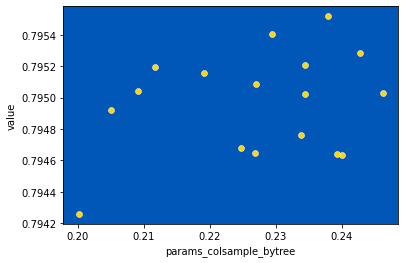

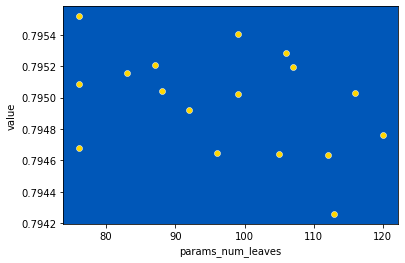

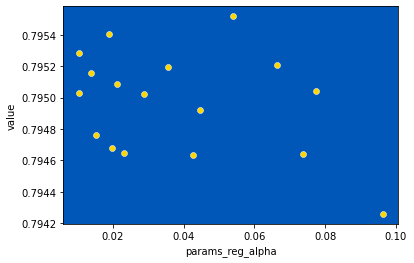

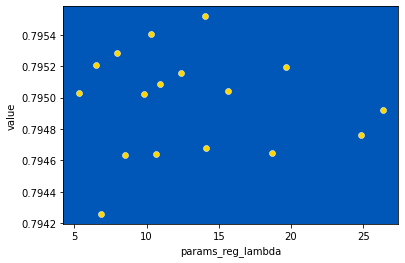

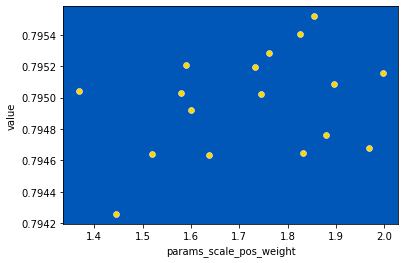

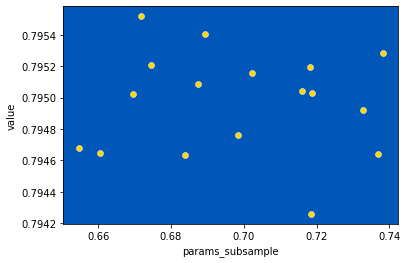

In [137]:
for col in get_cols(study_df, "params"):
    sns.scatterplot(data=study_df, x=study_df[col], y=study_df["value"])
    plt.show()

In [ ]:
# study_df = study.trials_dataframe()
# study_df = study_df.loc[study_df["state"] == "COMPLETE"].reset_index(drop=True)
# study_df.to_csv(f"{EXP_PATH}/lgbm_dart_exp/t.csv", index=False)

In [ ]:
np.mean(val_score_list)

In [ ]:
%%time
model_list, score_list, y_pred_list, held_out_index_list = [], [], [], []
model_dict = {}
X_val_dict = {}
y_val_dict = {}
y_score_dict = {}
kf = StratifiedKFold(n_splits=10)
for fold, (idx_tr, idx_va), n_est in zip(range(1, 10+1), kf.split(train, target), n_est_list):
    model_dict[fold] = joblib.load(f"{MODELS_PATH}/lgbm_models/model_{fold}.pkl")
    X_val_dict[fold] = train.iloc[idx_va][features]
    y_val_dict[fold] = target[idx_va]
    y_score_dict[fold] = model_dict[fold].predict_proba(X_val_dict[fold], raw_score=True)

In [ ]:
for i in range(1, 11):
    print(i, amex_metric_np(y_score_dict[i], y_val_dict[i]))

In [ ]:
full_train = pd.concat(list(X_val_dict.values()))
full_train.shape

In [ ]:
full_train_gt = np.concatenate(list(y_val_dict.values()))
len(full_train_gt)

In [ ]:
full_train_scores = np.concatenate(list(y_score_dict.values()))
len(full_train_scores)

In [ ]:
full_train.loc[:, "target"] = full_train_gt
full_train.loc[:, "score"] = full_train_scores

In [ ]:
# full_train.to_csv(f"{EVALUATION_DATA_PATH}/train_single_raw_score.csv", index=False)

In [ ]:
full_train

In [ ]:
%%time
model_list, score_list, y_pred_list, held_out_index_list = [], [], [], []
kf = StratifiedKFold(n_splits=10)
for fold, (idx_tr, idx_va), n_est in zip(range(1, 10+1), kf.split(train, target), n_est_list):
    X_train, X_val, y_train, y_val, model = None, None, None, None, None
    start_time = datetime.datetime.now()
    X_train = train.iloc[idx_tr][features]
    X_val = train.iloc[idx_va][features]
    y_train = target[idx_tr]
    y_val = target[idx_va]
    
    model = my_booster(n_estimators=n_est)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        model.fit(X_train, 
                  y_train,
                  eval_set=[(X_val, y_val)], 
                  eval_metric=[lgb_amex_metric],
                  callbacks=[log_evaluation(200)])
    X_train, y_train = None, None
    y_val_pred = model.predict_proba(X_val, raw_score=True)
    score = amex_metric(y_val, y_val_pred)
    n_trees = model.best_iteration_
    if n_trees is None: 
        n_trees = model.n_estimators
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | {str(datetime.datetime.now() - start_time)[-12:-7]} |"
          f" {n_trees:5} trees |"
          f"                Score = {score:.5f}{Style.RESET_ALL}")
    score_list.append(score)
    model_list.append(model)
    held_out_index_list.append(idx_va)
    # if INFERENCE:
    #     y_pred_list.append(model.predict_proba(test[features], raw_score=True))
        
    # if ONLY_FIRST_FOLD:
    #     break # we only want the first fold
    
print(f"{Fore.GREEN}{Style.BRIGHT}OOF Score:                       {np.mean(score_list):.5f}{Style.RESET_ALL}")

### Linear Analysis

In [ ]:
array = train_data.loc[train_data["customer_ID"] == train_data["customer_ID"][540]]["P_2"].astype("float32")

In [ ]:
np.polyfit(x=range(len(array)), y=array, deg=1)

In [ ]:
def calc_grad(array):
    if len(array) >= 2:
        gradient, y_intercept = np.polyfit(x=range(len(array)), y=array.astype("float32"), deg=1)
        return gradient
    else:
        return 0

In [ ]:
def calc_intercept(array):
    if len(array) >= 2:
        gradient, y_intercept = np.polyfit(x=range(len(array)), y=array.astype("float32"), deg=1)
        return y_intercept
    else:
        return array.values[0]

In [ ]:
temp = train.groupby("customer_ID").agg(P_2_grad=("P_2", calc_grad),
                                        P_2_intercept=("P_2", calc_intercept)).reset_index()
train_agg_summary = train_agg_summary.merge(temp, on="customer_ID", how="left")

In [ ]:
temp = test.groupby("customer_ID").agg(P_2_grad=("P_2", calc_grad),
                                       P_2_intercept=("P_2", calc_intercept)).reset_index()
test_agg_summary = test_agg_summary.merge(temp, on="customer_ID", how="left")

### Train Single LGBM

In [ ]:
kf = StratifiedKFold(n_splits=5)

In [ ]:
params = {
    'metrics': "custom",
    'first_metric_only': True, 
    'random_state': 1,
    'reg_alpha': 1, #0.0125, 
    'reg_lambda': 60, 
    'learning_rate': 0.1, 
    'n_estimators': 2000, 
    'colsample_bytree': 0.5, 
    'subsample': 0.7, 
    'subsample_freq': 5, 
    'min_child_samples': 2400, 
    'scale_pos_weight': 1.9, 
    'max_bins': 10, 
    'num_leaves': 50,
    'verbose': -1
}

In [ ]:
n_est_list = repeat(2000)

In [ ]:
# train_score_list, val_score_list = [], []
# for fold, (idx_tr, idx_va) in zip(range(1, 5+1), kf.split(train_agg, target)):
#     fold = str(fold)
#     X_train, y_train = train_agg.iloc[idx_tr], target[idx_tr]
#     train_data = lgb.Dataset(
#         X_train,
#         y_train
#     )
#     X_val, y_val = train_agg.iloc[idx_va], target[idx_va], 
#     valid_data = lgb.Dataset(
#         X_val,
#         y_val,
#         reference=train_data
#     )
#     print("Start Training")
#     with warnings.catch_warnings():
#         warnings.filterwarnings('ignore', category=UserWarning)
#         model = lgb.train(
#             params=params,
#             train_set=train_data, 
#             valid_sets=valid_data, 
#             feval=lgb_amex_metric, 
#             early_stopping_rounds=5,
#             categorical_feature=cat_columns,
#             callbacks=[
#                 log_evaluation(5),
#             ]
#         )
#     y_train_pred = model.predict(X_train, raw_score=True)
#     train_score, train_g, train_t4 = amex_metric(y_train, y_train_pred)
#     X_train, y_train = None, None
#     y_val_pred = model.predict(X_val, raw_score=True)
#     val_score, val_g, val_t4 = amex_metric(y_val, y_val_pred)
#     X_val, y_val = None, None
#     train_score_list.append(train_score)
#     val_score_list.append(val_score)
#     if val_score > best_scores_json["validation"][fold]:
#         print("Good")
#         # best_scores_json["train"][fold] = train_score
#         # best_scores_json["validation"][fold] = val_score
#         # with open(f'{CURRENT_EXP_PATH}/best_scores.json', "w") as outfile:
#         #     json.dump(best_scores_json, outfile)
#         # joblib.dump(model, f'{CURRENT_EXP_PATH}/models/model{fold}.pkl')
#     elif np.mean(train_score_list) >= np.mean(list(best_scores_json["train"].values())) + 0.05:
#         print(f"Train score too high (overfitting), start a new trial")
#     print(f"{Fore.BLUE}{Style.BRIGHT}Fold {fold} | Train Score = {train_score:.5f} ({train_g:.4f}, {train_t4:.4f})")
#     print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | Val Score = {val_score:.5f} ({val_g:.4f}, {val_t4:.4f}){Style.RESET_ALL}")

In [ ]:
np.mean(val_score_list)

In [ ]:
# imp_df = plot_feature_importance(model.feature_name_, model.feature_importances_, figsize=(16, 50), ascending=True, limit=300)

In [ ]:
imp_df.loc[imp_df["feature"] == "dummy"]

In [ ]:
zero_imp_features = sorted(imp_df.loc[imp_df["feature_importance"] == 0]["feature"].values.tolist())

In [ ]:
pd.Series(zero_imp_features, name="feature").to_csv(f"{DROP_FEATURES_PATH}/noob_features.csv", index=False)

In [ ]:
# train["target"] = target
# train.to_pickle(f"{EXP_PATH}/lgbm_gbdt_exp2/train_val.pkl")
# joblib.dump(train_score_list, f'{EXP_PATH}/lgbm_gbdt_exp2/5_fold_train_scores.pkl')
# joblib.dump(val_score_list, f'{EXP_PATH}/lgbm_gbdt_exp2/5_fold_val_scores.pkl')
# joblib.dump(val_idx_list, f'{EXP_PATH}/lgbm_gbdt_exp2/5_fold_val_indices.pkl')

### Tune LGBM using Optuna (Single)

In [ ]:
def objective(trial):
    params = {
        "objective": "binary",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 1,
        "reg_alpha": trial.suggest_float("reg_alpha", 0.001, 0.1, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 15, 30, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 0.015, 0.03, log=True),
        "n_estimators": trial.suggest_categorical("n_estimators", [1500, 1600, 1700, 1800, 1900, 2000]),
        "colsample_bytree": trial.suggest_categorical("colsample_bytree", np.arange(0.15, 0.4, 0.01)),
        "subsample": trial.suggest_categorical("subsample", np.arange(0.6, 0.8, 0.02)),
        "subsample_freq": trial.suggest_categorical("subsample_freq", [1, 2]),
        "min_child_samples": trial.suggest_categorical("min_child_samples", [2000, 2250, 2500]),
        "min_child_weight": trial.suggest_float("min_child_weight", 0.01, 450, log=True),
        "scale_pos_weight": trial.suggest_categorical("scale_pos_weight", np.arange(1.25, 2.5, 0.05)),
        "max_bins": trial.suggest_categorical("max_bins", np.arange(400, 550, 25)),
        "num_leaves": trial.suggest_categorical("num_leaves", np.arange(70, 180, 10)),
    }
    print(params)
    X_train, X_val, y_train, y_val = train_test_split(train_agg, target, test_size=0.2)
    model = LGBMClassifier(**params)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)], 
            eval_metric=[lgb_amex_metric],
            callbacks=[log_evaluation(200)]
        )
    y_train_pred = model.predict_proba(X_train, raw_score=True)
    train_score = amex_metric(y_train, y_train_pred)
    y_val_pred = model.predict_proba(X_val, raw_score=True)
    val_score = amex_metric(y_val, y_val_pred)
    print(f"Fold {fold} | Train Score = {train_score:.5f}")
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | Val   Score = {val_score:.5f}{Style.RESET_ALL}")
    return val_score

In [ ]:
study = optuna.create_study(direction="maximize")

In [ ]:
study.optimize(objective, n_trials=5)